### Import the necessary libraries

In [132]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import layers, models
import requests
import matplotlib.pyplot as plt

### Loading the data

In [133]:
# load the data
df = pd.read_pickle('data/words_df_all.pkl.gz')

In [134]:
df.head()

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
0,a01-000u-00-00,ok,154,"(408, 768, 27, 51)",AT,A,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,a01-000u-00-01,ok,154,"(507, 766, 213, 48)",NN,MOVE,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,a01-000u-00-02,ok,154,"(796, 764, 70, 50)",TO,to,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,a01-000u-00-03,ok,154,"(919, 757, 166, 78)",VB,stop,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,a01-000u-00-04,ok,154,"(1185, 754, 126, 61)",NPT,Mr.,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [135]:
print(df.shape)

(115319, 7)


### Splitting train, validation, and test data

In [136]:
for i, img in enumerate(df['ImageData']):
    if type(img) != np.ndarray:
        print(df['WordID'][i])
        # delete the current row from df
        df.drop(i, inplace=True)

a01-117-05-02
r06-022-03-04


In [137]:
# print the row in which imagdate is none
df[df['ImageData'].isnull()]

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
113621,r06-022-03-05,ok,184,"(924, 1304, 132, 29)",QL,more,None


In [138]:
df = df[df['ImageData'].notnull()]

In [139]:
print(df['ImageData'].apply(type).value_counts())

ImageData
<class 'numpy.ndarray'>    115316
Name: count, dtype: int64


In [140]:
print(len(df['Transcription'].unique()))

13549


In [271]:
# shuffle and select only 10% of the dataframe and save it to df_small
df = df.sample(frac=1).reset_index(drop=True)
df_small = df[:int(len(df) * 0.1)]

# Split data into training and validation sets
X = np.stack(df_small['ImageData'].values)  # Convert the list of images to a numpy array
y = df_small['Transcription'].values

In [272]:
# calculate the longest word
max_len = 0
for word in df['Transcription']:
    if len(word) > max_len:
        max_len = len(word)
print(max_len)

21


In [273]:
# print the top 40 value counts of the array y
print(pd.Series(y).value_counts()[:10])

,       611
the     556
.       465
of      312
to      304
and     249
a       223
in      181
"       153
that    114
Name: count, dtype: int64


In [275]:
def encode_to_labels(y):
    global vocabulary
    # create a list of the chartcaters vocabulary ordered alphabetically
    vocabulary = sorted(set(''.join(y)))

    # create a dictionary mapping each character to the vocabulary list index. do not use 0.
    char_to_num = {char:idx+1 for idx, char in enumerate(vocabulary)}

    # transform y values to numerical using the char_to_num dictionary, using 0 for padding. the length of each word is the maximum length of the words in the dataset
    y_encoded = []
    for word in y:
        word_encoded = [char_to_num[char] for char in word]
        y_encoded.append(word_encoded)

    # pad the encoded values (fill with 0s to the right)
    y_encoded = tf.keras.preprocessing.sequence.pad_sequences(y_encoded, padding='post')

    # normalize the values
    y_encoded = y_encoded / np.array(len(vocabulary))

    return y_encoded

y = encode_to_labels(y)

# one-hot enconde instead of encode_to_labels
y = to_categorical(y, num_classes=len(vocabulary)+1)

print(y.shape)

# add padding to y to match the image size
y = np.pad(y, ((0,0),(0,32-y.shape[1]),(0,0)), mode='constant', constant_values=0)

print(y.shape)

(11531, 21, 78)


(11531, 32, 78)


In [286]:
from pprint import pprint

np.savetxt('y0.txt', y[0], fmt='%f')    

In [287]:
print(X.shape)
print(y.shape)

(11531, 32, 128, 1)
(11531, 32, 78)


In [288]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(9224, 32, 128, 1)
(9224, 32, 78)
(1153, 32, 128, 1)
(1153, 32, 78)
(1154, 32, 128, 1)
(1154, 32, 78)


who


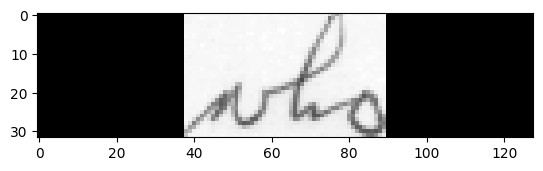

sedate


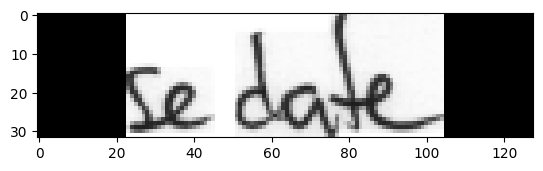

"


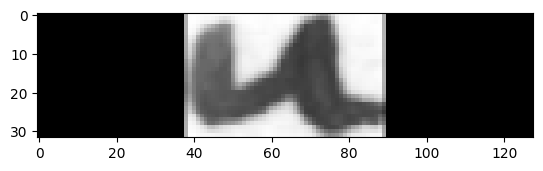

bird


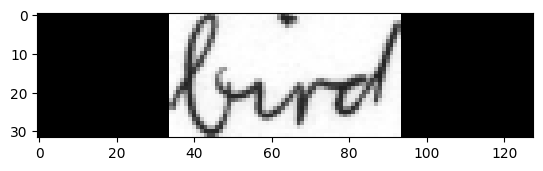

say


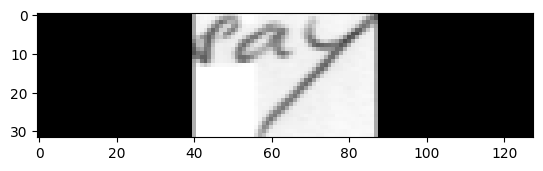

boy


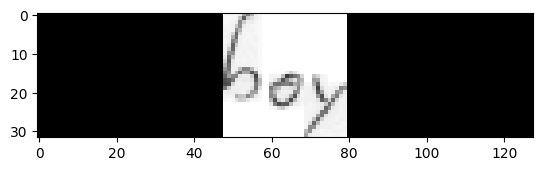

the


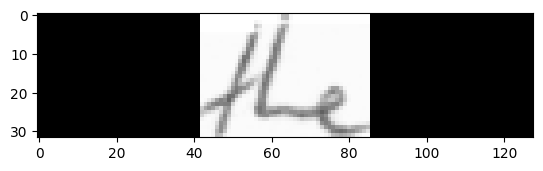

he


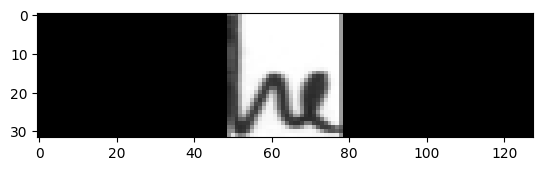

and


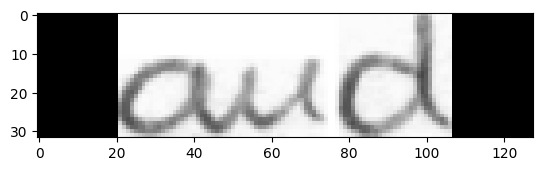

an


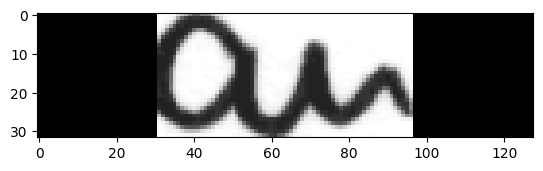

In [223]:
# display the first 10 images in the training set df['ImageData] with the corresponding transcription df['Transcription']
# use the dataframe 
# print one image per line

for i in range(10):
    print(df['Transcription'][i])
    plt.imshow(df['ImageData'][i][:,:,0], cmap='gray')
    plt.show()

In [224]:
# save value_counts of transcription of df to a df and export it to txt
df['Transcription'].value_counts().to_csv('data/transcription_value_counts_all.txt', header=None, sep=' ')

In [281]:
# print the shapes of training x and y
print(X_train.shape)
print(y_train.shape)


(9224, 32, 128, 1)
(9224, 21, 78)


In [261]:
X_train_0 = X_train[0]
y_train_0 = y_train[0]
# squeeze the image to remove the last dimension
X_train_0 = np.squeeze(X_train_0)

# write to txt x_train_0 and y_train_0, different files, no scientific notation
np.savetxt('X_train_0.txt', X_train_0, fmt='%f')
np.savetxt('y_train_0.txt', y_train_0, fmt='%f')



In [282]:
print(y_train[0])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [263]:
print(len(y_train[0]))

21


### Neural Networks

- You always have to give a 4D array as input to the CNN. So input data has a shape of (batch_size, height, width, depth).

<img src="convnet_input.png" width="500" height="400">

#### (Model 1) Starting simple

In [264]:
# Plotting the Training and Validation Loss and Accuracy
def plot_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Get training and test accuracy histories
    training_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, test_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [289]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (9224, 32, 128, 1)
y_train shape: (9224, 32, 78)


In [270]:
print(y_train[0])

[0.73684211 0.85526316 0.89473684 0.92105263 0.93421053 0.84210526
 0.67105263 0.92105263 0.72368421 0.81578947 0.98684211 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [335]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Image dimensions
img_width = X_train.shape[2]
img_height = X_train.shape[1]

# CNN parameters
num_filters = 64
kernel_size = (3, 3)
pool_size = (2, 2)

# RNN parameters
num_units = 128

# Output parameters
num_classes = len(vocabulary)+1  # for example, 26 letters + 1 for blank
max_text_length = y_train.shape[1]  # maximum length of the output word

input_img = Input(shape=(img_height, img_width, 1))  # Assuming the image is grayscale

# CNN layers
x = Conv2D(num_filters, kernel_size, activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=pool_size, padding='same')(x)
x = Conv2D(num_filters*2, kernel_size, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=pool_size, padding='same')(x)

# Reshaping to fit into RNN
new_shape = ((img_width // (pool_size[0] ** 2)), (img_height // (pool_size[1] ** 2)) * num_filters*2)
x = Reshape(target_shape=new_shape)(x)

# RNN layers
x = Bidirectional(LSTM(num_units, return_sequences=True))(x)
x = Bidirectional(LSTM(num_units, return_sequences=True))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

early_stopping = EarlyStopping(
    monitor='loss',        # Monitor the training loss
    patience=2,            # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Log when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the lowest loss
)

# Define the model
model = Model(inputs=input_img, outputs=output)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=100,  # Set a higher number since EarlyStopping will take care of stopping early
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

# Plot the training and validation loss and accuracy
plot_history(history)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_153 (Conv2D)         (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_152 (MaxPool  (None, 16, 64, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_154 (Conv2D)         (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_153 (MaxPool  (None, 8, 32, 128)        0         
 ing2D)                                                          
                                                                 
 reshape_30 (Reshape)        (None, 32, 1024)          0  

Epoch 1/100
289/289 [==============================] - 40s 131ms/step - loss: 0.1228 - accuracy: 0.9965 - val_loss: 0.1121 - val_accuracy: 0.9999
Epoch 2/100
289/289 [==============================] - 38s 132ms/step - loss: 0.1120 - accuracy: 0.9999 - val_loss: 0.1129 - val_accuracy: 0.9999
Epoch 3/100
 42/289 [===>..........................] - ETA: 31s - loss: 0.1118 - accuracy: 1.0000

KeyboardInterrupt: 

In [291]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 1.0


In [298]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

def distortion_free_resize(image, target_size=(128, 32)):
# Calculate the ratio of the target dimensions and the image
    target_ratio = target_size[1] / target_size[0]
    img_ratio = image.shape[0] / image.shape[1]

    # Determine the dimensions to which the image should be resized
    if img_ratio <= target_ratio:
        # Image is more horizontal; fit to width
        new_size = (target_size[0], int(image.shape[0] * target_size[0] / image.shape[1]))
    else:
        # Image is more vertical; fit to height
        new_size = (int(image.shape[1] * target_size[1] / image.shape[0]), target_size[1])
    
    # Resize the image to fit within the target rectangle
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Calculate padding to center the image
    pad_x = (target_size[0] - resized_image.shape[1]) // 2
    pad_y = (target_size[1] - resized_image.shape[0]) // 2

    # Apply padding to center the image within the target rectangle
    padded_image = cv2.copyMakeBorder(resized_image, pad_y, pad_y, pad_x, pad_x, cv2.BORDER_CONSTANT, value=0)

    # Adjust if the padding isn't perfectly even (e.g., due to odd number dimensions)
    if padded_image.shape[0] != target_size[1] or padded_image.shape[1] != target_size[0]:
        padded_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_AREA)

    return padded_image


def load_image(file_path):
    # Load an image in grayscale mode
    return cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)

def preprocess_image(image, target_size=(128, 32)):
    """
    Preprocesses an image by resizing it to the target size, normalizing it, and adding a channel dimension.

    Parameters:
    - image: The input image to be preprocessed.
    - target_size: The desired size of the image after resizing. Default is (128, 32).

    Returns:
    - The preprocessed image.
    """

    image = load_image(image)

    
    # Resize the image to the target size
    #image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    image = distortion_free_resize(image, target_size)

    # Normalize the image
    image = image.astype(np.float32) / 255.0
    
    # Add a channel dimension ([height, width] -> [height, width, 1])
    image = np.expand_dims(image, axis=-1)
    

    # reduce noise
    
    return image

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def decode_from_labels(encoded_y):
    # Inverse the one-hot encoding
    y_pred = np.argmax(encoded_y, axis=-1)

    # Inverse the normalization
    y_pred = y_pred * len(vocabulary)

    decoded_words = []
    for word_encoded in y_pred:
        # Remove padding (zeros)
        word_encoded = word_encoded[word_encoded != 0]
        
        # Map numbers back to characters and concatenate
        word = ''.join(vocabulary[idx-1] for idx in word_encoded if idx > 0)
        decoded_words.append(word)

    return decoded_words


['']


In [334]:
print(img.shape)

(32, 128, 1)


In [333]:
# Read the image paths from the file
with open('data/img_paths.txt', 'r') as file:
    img_paths = file.read().splitlines()

# Path for the predictions file
prediction_path = 'pred/prediction.txt'
os.makedirs(os.path.dirname(prediction_path), exist_ok=True)

# Open the prediction file once and write all predictions to avoid opening it repeatedly
with open(prediction_path, 'w') as pred_file:
    # Iterate through the image paths
    for index, img_path in enumerate(img_paths[:100], 1):  # Start index at 1
        # Preprocess the image
        img = preprocess_image(img_path)

        # Add an extra dimension to the image
        #img = np.expand_dims(img, axis=0)

        # Predict the transcription
        prediction = model.predict(img)

        # Decode the prediction
        decoded_prediction = decode_from_labels(prediction)[0]

        # Write the indexed prediction to the file
        pred_file.write(f"{index}-{decoded_prediction}\n")

2023-12-27 20:32:32.153387: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:761 : INVALID_ARGUMENT: convolution input must be 4-dimensional: [32,128,1]


InvalidArgumentError: Graph execution error:

Detected at node model_31/conv2d_151/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_53581/2410014171.py", line 17, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 5395, in relu

convolution input must be 4-dimensional: [32,128,1]
	 [[{{node model_31/conv2d_151/Relu}}]] [Op:__inference_predict_function_563101]

In [316]:
decoded_y = decode_from_labels(prediction)
print(decoded_y)

['']


In [338]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_improved_cnn(input_shape, output_length, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Add flatten layer
    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # Output layer with 'num_classes' units
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    # Output layer with no activation function
    model.add(layers.Dense(num_classes))
    
    return model

def create_improved_cnn(input_shape, output_length, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer with 'softmax' activation for multi-class classification
    # model.add(layers.Dense(num_classes, activation='softmax'))

    # adapt the output to one hot encoding of the label (must be (none, 32, len(vocabulary))
    model.add(layers.Dense(output_length, activation='sigmoid'))
    

    return model


# Define your parameters
input_shape = X_train.shape[1:]  # Replace with actual shape (32, 128, 1)
output_length = y_train.shape[1]  # Replace with actual length 18
num_classes =  y_train.shape[1] # Replace with the actual number of classes

"""# Create and compile the improved model
model = create_improved_cnn(input_shape, output_length, num_classes)
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

plot_history(history)"""

# Create and compile the improved model
model = create_improved_cnn(input_shape, output_length, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000001),
              loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

model.summary()

# Implement early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
plot_history(history)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_161 (Conv2D)         (None, 32, 128, 128)      1280      
                                                                 
 batch_normalization_24 (Ba  (None, 32, 128, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_160 (MaxPool  (None, 16, 64, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_162 (Conv2D)         (None, 16, 64, 64)        73792     
                                                                 
 batch_normalization_25 (Ba  (None, 16, 64, 64)        256       
 tchNormalization)                                               
                                                     

ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 32, 78) and (None, 32) are incompatible


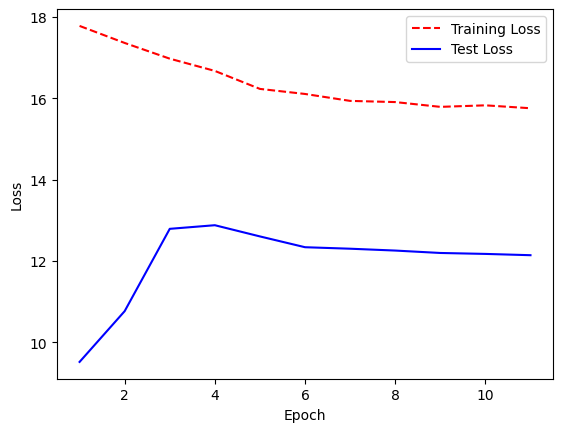

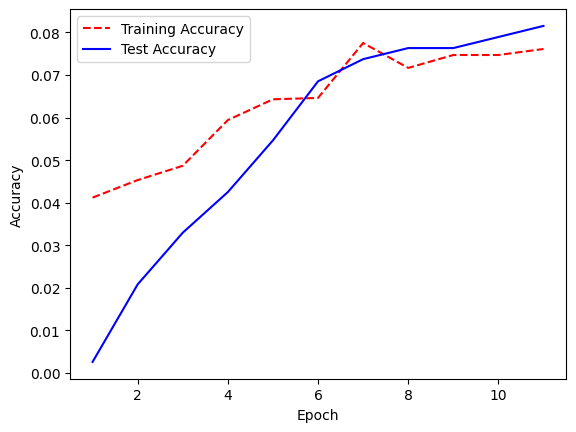

In [233]:
plot_history(history)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 16, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 16, 64, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 8, 32, 64)         0         
 ng2D)                                                           
                                                                 
 reshape_6 (Reshape)         (None, 32, 512)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 32, 256)         

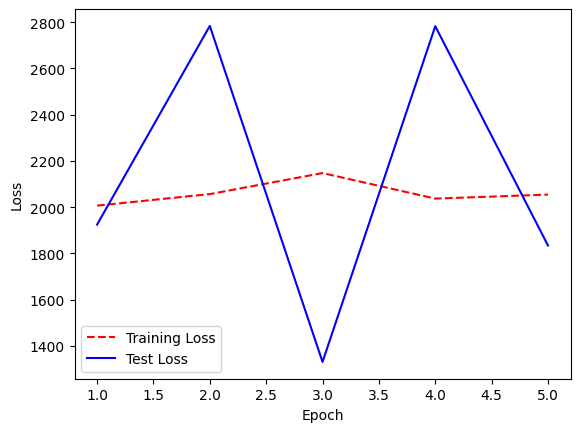

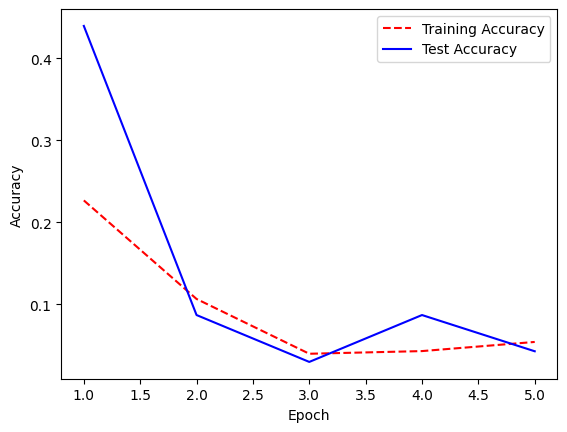

In [174]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_rnn(input_shape, output_length, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Prepare for the RNN layer
    model.add(layers.Reshape(target_shape=(-1, 64 * (input_shape[0] // 4))))  # Adjust depending on your input shape

    # RNN Layer - LSTM
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(64)))

    # Dense Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Output layer without activation
    model.add(layers.Dense(num_classes))

    
    return model

# Define your parameters
input_shape = X_train.shape[1:]  # Replace with actual shape (32, 128, 1)
output_length = y_train.shape[1]  # Replace with actual length 18
num_classes = y_train.shape[1] # Replace with the actual number of classes

# Create and compile the CNN-RNN model
model = create_cnn_rnn(input_shape, output_length, num_classes)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

plot_history(history)

#### (Model 2) Adding Embedding layer

In [203]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model_with_embedding(input_shape, output_length, num_classes):
    # Image model
    image_input = tf.keras.Input(shape=input_shape, name='image_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Label input for embedding
    label_input = tf.keras.Input(shape=(output_length,), name='label_input')
    label_embedding = layers.Embedding(input_dim=num_classes, output_dim=50)(label_input)
    
    # Combine image features with label embeddings
    combined = layers.concatenate([x, layers.Flatten()(label_embedding)])
    
    # Add a dense layer
    combined = layers.Dense(128, activation='relu')(combined)
    
    # Output layer
    output = layers.Dense(num_classes, activation='sigmoid')(combined)

    # Create model
    model = models.Model(inputs=[image_input, label_input], outputs=output)

    return model

# Define your parameters
input_shape = X_train.shape[1:]
output_length = y_train.shape[1]
num_classes = 

# Create and compile the model
model = create_model_with_embedding(input_shape, output_length, num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

plot_history(history)


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_112 (Conv2D)         (None, 32, 128, 32)          320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_111 (MaxPool  (None, 16, 64, 32)           0         ['conv2d_112[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 conv2d_113 (Conv2D)         (None, 16, 64, 64)           18496     ['max_pooling2d_111[0][

ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_25" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 32, 128, 1) dtype=float32>]


In [202]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend

# Define a custom CTC layer
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

def create_model_with_ctc(input_shape, output_length, num_classes):
    # Image model
    image_input = tf.keras.Input(shape=input_shape, name='image_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Reshape(target_shape=(-1, 64 * (input_shape[0] // 4)))(x)  # Prepare for RNN

    # RNN layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # Output layer for CTC
    x = layers.Dense(num_classes, activation='softmax')(x)
    # Output layer for CTC
    # x = layers.Dense(num_classes + 1, activation='log_softmax')(x) # Use log softmax instead of softmax

    # Labels input
    labels = layers.Input(name='labels', shape=(None,))

    # CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)
    
    # Define the model
    model = models.Model(inputs=[image_input, labels], outputs=output)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
    model.compile(optimizer=opt)

    return model

# Define your parameters
input_shape = (32, 128, 1)  # Replace with actual shape
output_length = 21  # Replace with actual length
num_classes = 78  # Adjusted to cover all label values


# Create and compile the model
model = create_model_with_ctc(input_shape, output_length, num_classes)

# Print summary
model.summary()


history = model.fit(
    [X_train, y_train],  # Provide image and label inputs
    y_train,  # True labels for the CTC loss
    epochs=5,
    validation_data=([X_val, y_val], y_val)  # Validation data
)

plot_history(history)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_110 (Conv2D)         (None, 32, 128, 32)          320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_109 (MaxPool  (None, 16, 64, 32)           0         ['conv2d_110[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 conv2d_111 (Conv2D)         (None, 16, 64, 64)           18496     ['max_pooling2d_109[0][

2023-12-27 18:06:52.732370: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732385: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732435: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732451: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732458: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732462: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732473: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732496: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732515: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.732533: W ./tensorflow/core/util/ct

  5/289 [..............................] - ETA: 18s - loss: inf

2023-12-27 18:06:52.976580: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976607: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976617: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976623: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976639: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976650: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976658: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976672: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976678: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:52.976691: W ./tensorflow/core/util/ct

  8/289 [..............................] - ETA: 20s - loss: inf

2023-12-27 18:06:53.260412: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260437: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260446: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260453: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260465: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260500: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260513: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260524: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260533: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.260549: W ./tensorflow/core/util/ct

 11/289 [>.............................] - ETA: 21s - loss: inf

2023-12-27 18:06:53.508933: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.508975: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509000: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509008: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509024: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509057: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509074: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509083: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509108: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.509113: W ./tensorflow/core/util/ct

 15/289 [>.............................] - ETA: 21s - loss: inf

2023-12-27 18:06:53.796969: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.796998: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797004: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797018: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797033: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797042: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797054: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797067: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797073: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:53.797077: W ./tensorflow/core/util/ct

 16/289 [>.............................] - ETA: 21s - loss: inf

2023-12-27 18:06:54.014943: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.014986: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015009: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015023: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015037: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015041: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015059: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015064: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015077: W ./tensorflow/core/util/ctc/ctc_loss_calculator.h:499] No valid path found.
2023-12-27 18:06:54.015089: W ./tensorflow/core/util/ct

InvalidArgumentError: Graph execution error:

Detected at node model_24/ctc_loss/CTCLoss defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_53581/4210470256.py", line 69, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_53581/617886189.py", line 18, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 7169, in ctc_batch_cost

Saw a non-null label (index >= num_classes - 1) following a null label, batch: 24 num_classes: 78 labels: 66,73,56,69,11,56,64,67,59,52,70,60,77,60,65,58,0,0,0 labels seen so far: 66,73,56,69,11,56,64,67,59,52,70,60
	 [[{{node model_24/ctc_loss/CTCLoss}}]] [Op:__inference_train_function_388657]

In [200]:
print("Unique training labels:", np.unique(y_train))
print("Unique validation labels:", np.unique(y_val))


Unique training labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
Unique validation labels: [ 0  1  2  3  4  5  6  7  8 10 11 12 14 15 16 17 18 19 20 21 23 24 25 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
